Text(0,0.5,'O-C [min]')

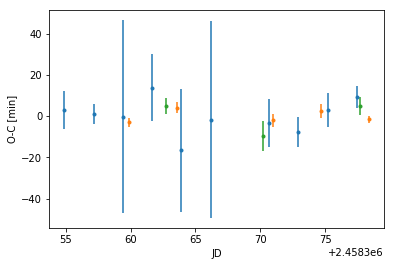

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

b_times = np.load('307210830/transit_times_b.npy')[0, :]
b_uncertainties = np.load('307210830/transit_times_b.npy')[1, :]
b_epoch = np.array([0, 1, 2, 3, 4, 5, 7, 8, 9, 10])

c_times = np.load('307210830/transit_times_c.npy')[0, :]
c_uncertainties = np.load('307210830/transit_times_c.npy')[1, :]
c_epoch = np.array([0, 1, 3, 4, 5]) + 1

d_times = np.load('307210830/transit_times_d.npy')[0, :]
d_uncertainties = np.load('307210830/transit_times_d.npy')[1, :]
d_epoch = np.arange(len(d_times)) + 1

plt.errorbar(b_times, 24*60*(b_times - np.polyval(np.polyfit(b_epoch, b_times, 1), b_epoch)), 24*60*b_uncertainties, fmt='.')
plt.errorbar(c_times, 24*60*(c_times - np.polyval(np.polyfit(c_epoch, c_times, 1), c_epoch)), 24*60*c_uncertainties, fmt='.')
plt.errorbar(d_times, 24*60*(d_times - np.polyval(np.polyfit(d_epoch, d_times, 1), d_epoch)), 24*60*d_uncertainties, fmt='.')

plt.xlabel('JD')
plt.ylabel('O-C [min]')

In [15]:
from astropy.constants import G, M_sun, R_sun
import astropy.units as u

def period_to_a(params, M_star=.305*M_sun, R_star=.317*R_sun): 
    return (((G * M_star / (4 * np.pi**2) * (params.per * u.day)**2)**(1/3)) / R_star).decompose().value

In [16]:
from batman import TransitParams, TransitModel

paramsb = TransitParams()
paramsb.per = 2.253014
paramsb.t0 = 2458354.906208
paramsb.duration = 1/24
paramsb.rp = np.sqrt(571.225532 * 1e-6)
paramsb.a  = period_to_a(paramsb)
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 3.690613
paramsc.inc = 90
paramsc.t0 = 2458356.203764
paramsc.duration = 1/24
paramsc.rp = np.sqrt(1828.769675 * 1e-6)
paramsc.a = period_to_a(paramsc)
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

paramsd = TransitParams()
paramsd.per = 7.451113
paramsd.inc = 89
paramsd.t0 = 2458355.2864
paramsd.duration = 1/24
paramsd.rp = np.sqrt(1641.527815 * 1e-6)
paramsd.a = period_to_a(paramsd)
paramsd.u = [0.5971, 0.1172]
paramsd.limb_dark = 'quadratic'
paramsd.w = 90
paramsd.ecc = 0

In [17]:
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

period_b_init = paramsb.per
period_c_init = paramsc.per
period_d_init = paramsd.per

mass_b_init = 1 * float(M_earth/M_sun) 
mass_c_init = 1 * float(M_earth/M_sun) 
mass_d_init = 1 * float(M_earth/M_sun) 

# b
a = period_to_a(paramsb)
b = 0

inclination_b = np.degrees(np.arccos(b/a))

# c
a = period_to_a(paramsc) 
b = 0

inclination_c = np.degrees(np.arccos(b/a))

# d
a = period_to_a(paramsd) 
b = 0

inclination_d = np.degrees(np.arccos(b/a))

# mass_b_init_err = 0.154 * float(M_earth/M_sun) 
# mass_c_init_err = 0.142 * float(M_earth/M_sun) 

In [18]:
phase = 360 * (((b_times.min() - c_times.min())/period_c_init) % 1 )
phase_init_b = 355
phase_init_c = phase
phase_init_d = 341.5
b = Planet(mass=mass_b_init, period=period_b_init, eccentricity=0, inclination=inclination_b, 
           longnode=0, argument=90, mean_anomaly=phase_init_b)
c = Planet(mass=mass_c_init, period=period_c_init, eccentricity=0, inclination=inclination_c, 
           longnode=0, argument=90, mean_anomaly=phase_init_c)
d = Planet(mass=mass_d_init, period=period_d_init, eccentricity=0, inclination=inclination_d, 
           longnode=0, argument=90, mean_anomaly=phase_init_d)
result = ttvfast(planets=[b, c, d], stellar_mass=0.305, time=b_times.min(), dt=period_b_init/100, total=b_times.min()+100)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)
indices_d = (planet_ind == 2) & np.in1d(epoch, d_epoch)

epoch_c = epoch[indices_c]
model_times_b = times[indices_b]
model_times_c = times[indices_c]
model_times_d = times[indices_d]

# logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
# logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

model_times_b - b_times, model_times_c - c_times, model_times_d - d_times

(array([0.03129186, 0.03232501, 0.03297166, 0.02282024, 0.0434915 ,
        0.03275966, 0.03325635, 0.03589915, 0.02811243, 0.02340512]),
 array([-0.00021353, -0.00535866, -0.00148758, -0.00469473, -0.00233863]),
 array([-0.00263329,  0.00342167, -0.01040109]))

In [19]:
import emcee
from corner import corner

from astropy.constants import G, M_sun
M_starM_sun = 0.305
M_star = M_starM_sun * M_sun
a_b = ( ( (G * M_star)/(4 * np.pi**2) * (period_b_init*u.day)**2 )**(1/3) ).decompose()
a_c = ( ( (G * M_star)/(4 * np.pi**2) * (period_c_init*u.day)**2 )**(1/3) ).decompose()
a_d = ( ( (G * M_star)/(4 * np.pi**2) * (period_d_init*u.day)**2 )**(1/3) ).decompose()

def lnprob(p):
    mass_b, mass_c, mass_d, period_b, period_c, period_d, lam_b, lam_c, lam_d, w_b, w_c, w_d = p

    if (mass_b < 0 or mass_c < 0 or mass_d < 0 or lam_b > 360 or lam_b < 0
         or lam_c > 360 or lam_c < 0 or lam_d > 360 or lam_d < 0 or 
         w_b > 360 or w_b < 0 or w_c > 360 or w_c < 0 or w_d > 360 or w_d < 0): 
        return -np.inf
    
    ecc_b = 0
    ecc_c = 0
    ecc_d = 0
    
    # Hill stability criterion from Gladman 1993 Eqn. 21 for planets b and c
    gamma1 = np.sqrt(1 - ecc_b**2)
    gamma2 = np.sqrt(1 - ecc_c**2)
    mu1 = mass_b * M_starM_sun
    mu2 = mass_c * M_starM_sun
    alpha = mu1 + mu2
    Delta = (a_c - a_b)/a_b
    delta = np.sqrt(1 + Delta)
    
    if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
        1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
        return -np.inf
    
    # Hill stability criterion from Gladman 1993 Eqn. 21 for planets c and d
    gamma1 = np.sqrt(1 - ecc_c**2)
    gamma2 = np.sqrt(1 - ecc_d**2)
    mu1 = mass_c * M_starM_sun
    mu2 = mass_d * M_starM_sun
    alpha = mu1 + mu2
    Delta = (a_d - a_c)/a_c
    delta = np.sqrt(1 + Delta)
    
    if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
        1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
        return -np.inf
    
    b = Planet(mass=mass_b, period=period_b, eccentricity=0, inclination=inclination_b, 
               longnode=lam_b, argument=90, mean_anomaly=w_b)
    c = Planet(mass=mass_c, period=period_c, eccentricity=0, inclination=inclination_c, 
               longnode=lam_c, argument=90, mean_anomaly=w_c)
    d = Planet(mass=mass_d, period=period_d, eccentricity=0, inclination=inclination_d, 
               longnode=lam_d, argument=90, mean_anomaly=w_d)
    result = ttvfast(planets=[b, c, d], stellar_mass=0.305, time=b_times.min(), 
                     dt=period_b_init/30, total=b_times.min()+100)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    # Parse results for planets e and f
    indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
    indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)
    indices_d = (planet_ind == 2) & np.in1d(epoch, d_epoch)

    epoch_b = epoch[indices_b]
    epoch_c = epoch[indices_c]
    epoch_d = epoch[indices_d]

    model_times_b = times[indices_b]
    model_times_c = times[indices_c]
    model_times_d = times[indices_d]

    # Compute chi^2 for transit times of e and f
    if model_times_b.shape[0] != b_times.shape[0]: 
        print(p)
    
    logchi2_b = -0.5 * np.sum( (model_times_b - b_times)**2 / b_uncertainties**2 )
    logchi2_c = -0.5 * np.sum( (model_times_c - c_times)**2 / c_uncertainties**2 )
    logchi2_d = -0.5 * np.sum( (model_times_d - d_times)**2 / d_uncertainties**2 )
    
    # Add log prior for planet mass from Gaia + forecaster
#     lnprior = (-0.5 * (mass_b - mass_b_init)**2 / mass_b_init_err**2
#                -0.5 * (mass_c - mass_c_init)**2 / mass_c_init_err**2)
    return logchi2_b + logchi2_c + logchi2_d

ndim, nwalkers = 12, 50

init_masses = [mass_b_init, mass_c_init, mass_d_init, 
               period_b_init, period_c_init, period_d_init, 0, 0, 0, 
               phase_init_b, phase_init_c, phase_init_d]

p0 = [init_masses + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
p1 = sampler.run_mcmc(p0, 10000)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, 10000);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


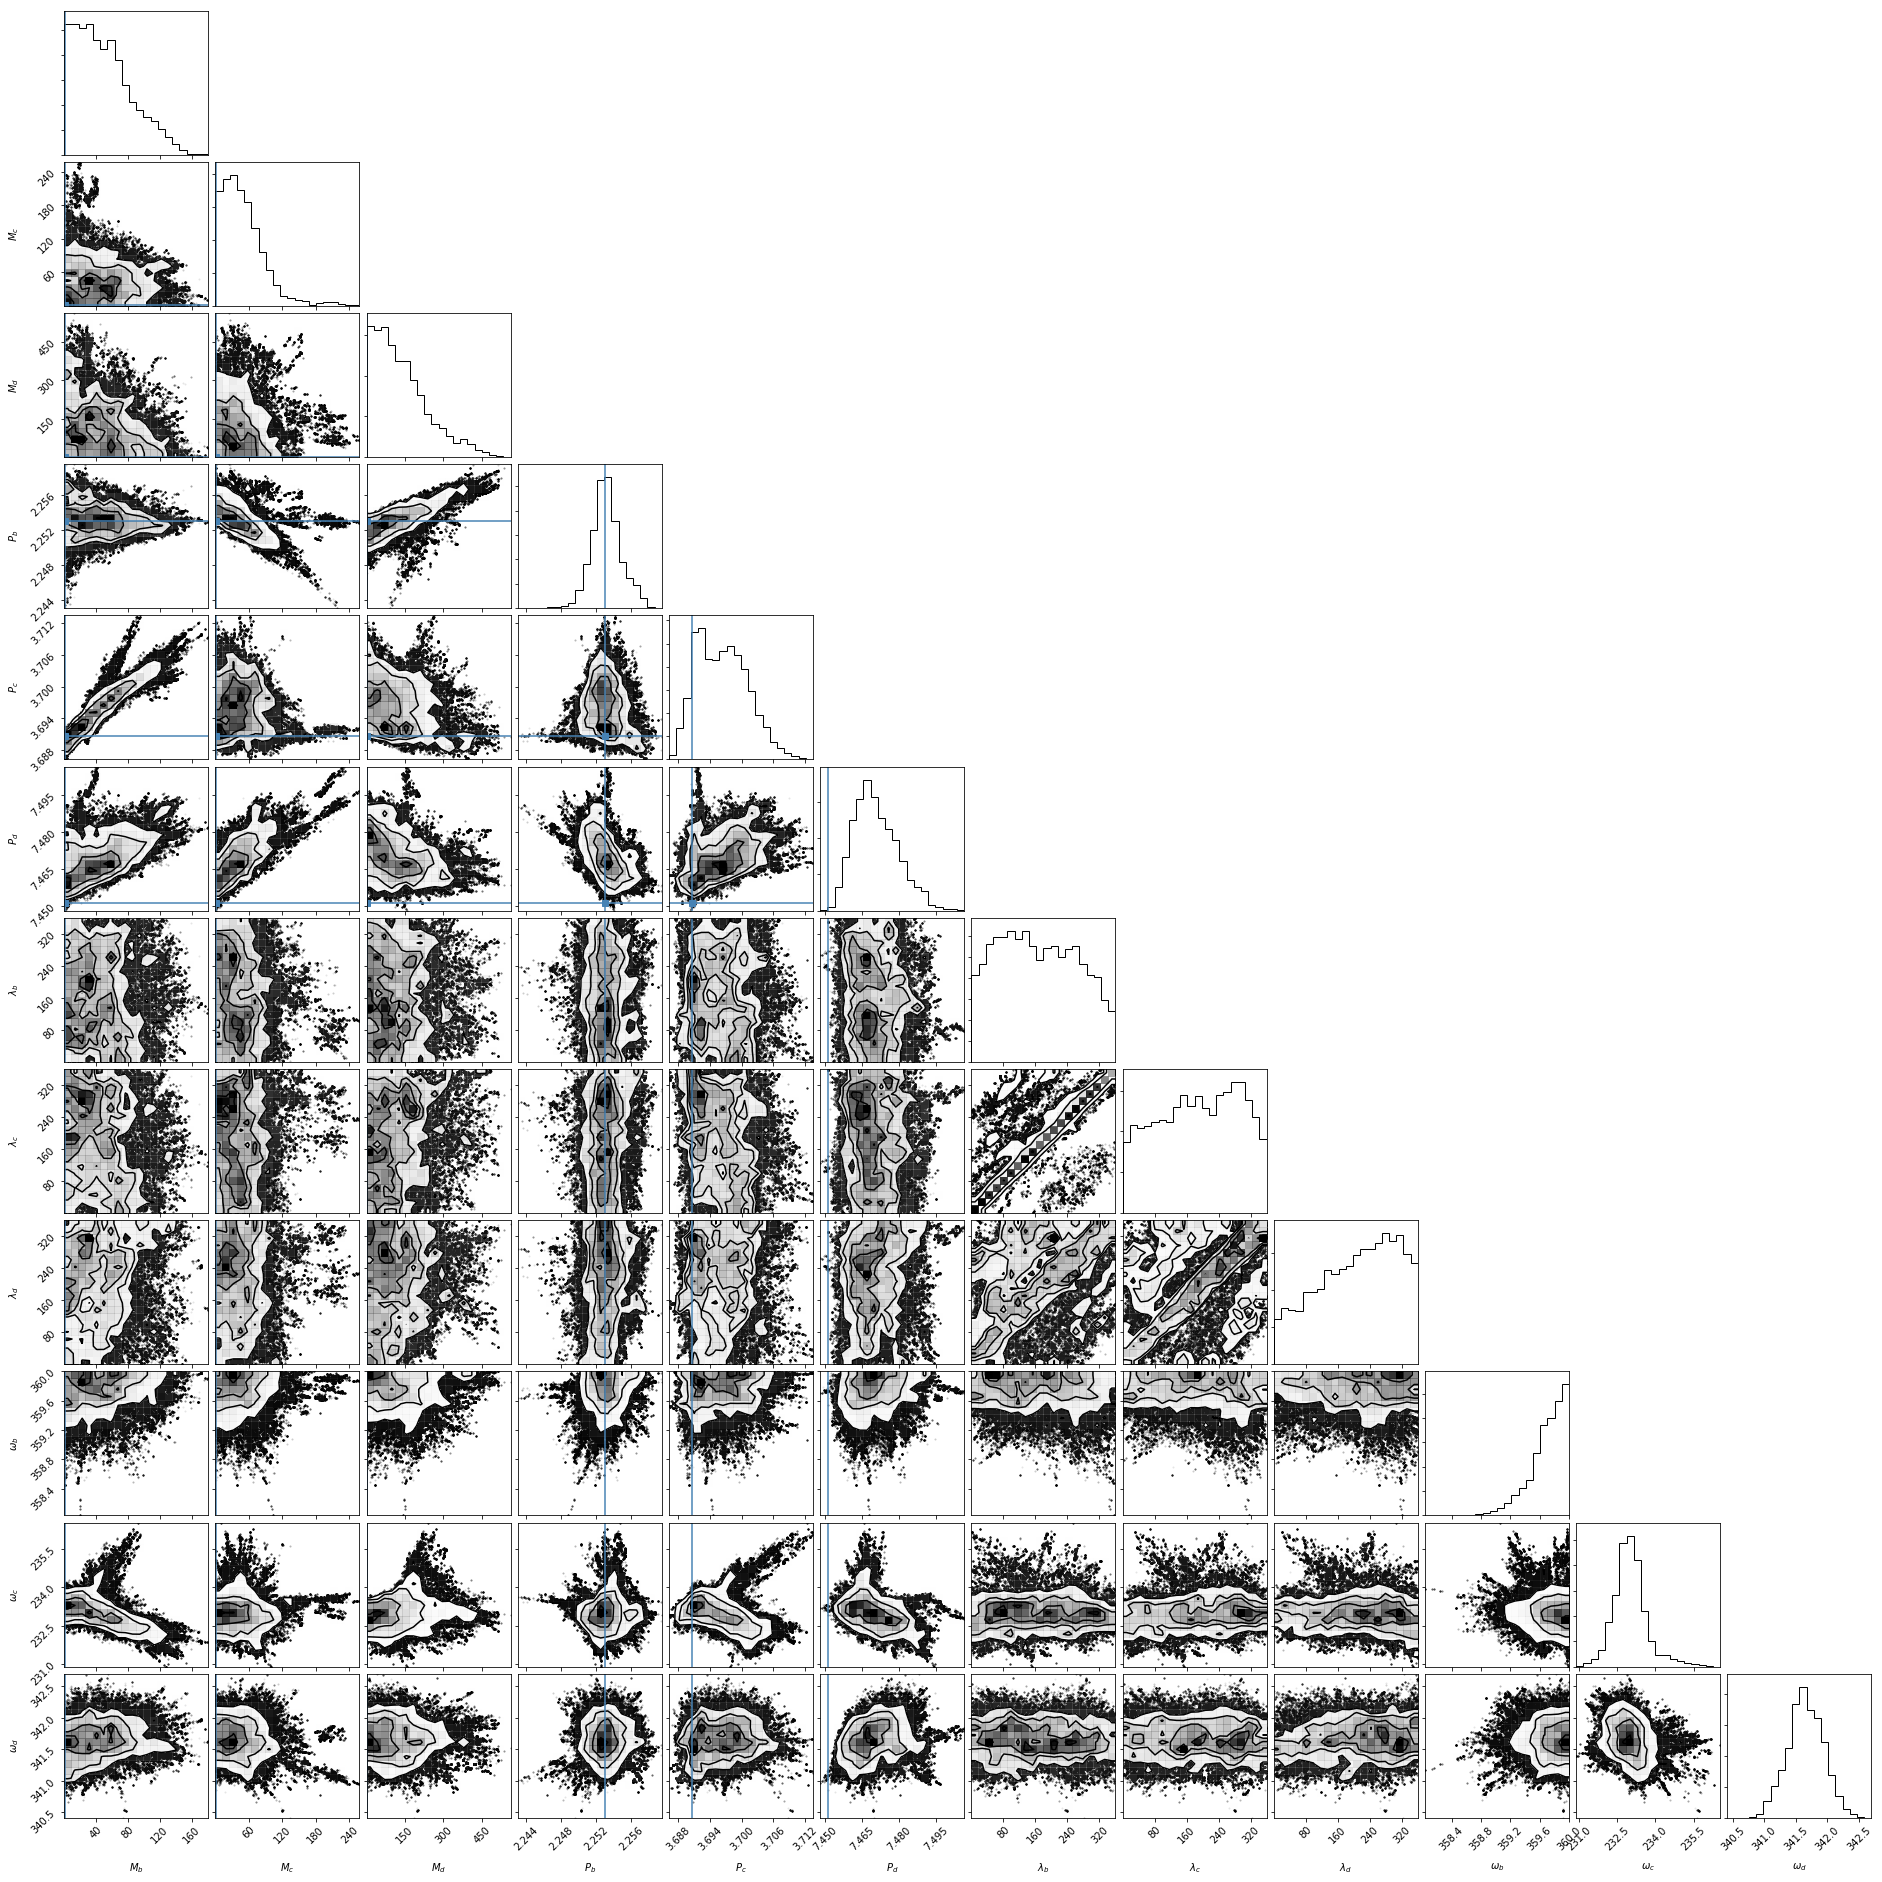

In [21]:
chains = np.copy(sampler.flatchain)
chains[:, :3] /= float(M_earth/M_sun)

corner(chains, 
       truths=[mass_b_init/float(M_earth/M_sun), mass_c_init/float(M_earth/M_sun), 
               mass_d_init/float(M_earth/M_sun), period_b_init, period_c_init, period_d_init, 
               None, None, None, None, None, None, None, None], 
       labels=['$M_b$', '$M_c$', "$M_d$", "$P_b$", "$P_c$", "$P_d$", '$\lambda_b$', "$\lambda_c$",
               "$\lambda_d$", "$\omega_b$", "$\omega_c$", "$\omega_d$"]);
plt.savefig('ttv_recovery_toi175.png', bbox_inches='tight', dpi=300)